In [1]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.image import mean_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

from utils import *

In [2]:
dataset_id = 'ds000171'
subject = '01'

subject_dir = 'sub-control{}'.format(subject)

sample_path = "/home/jovyan/data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
data_path = op.join(preproc_root, 'sub-control01/func')


## Preprocessing

In [3]:
#POUR LINSTANT J'AI PRIS LE FMRI DU RUN 1 MAIS FAUDRA EN PRENDRE UN QUI EST CONCATENE JE SAIS JUSTE PAS LEQUEL
#JSP A QUEL POINT IL FAUT FAIRE DU PREPROCESSING ??


img = nib.load(op.join(data_path,'concat_int_cleaned_fd_corrected.nii.gz_smoothed-6mm.nii.gz'))
#img = nib.load(op.join(data_path,'sub-control01_task-music_concat_int_cleaned_bold_moco.nii.gz'))
#img = nib.load(op.join(data_path,'sub-control01_task-music_run-1_bold_moco.nii.gz')) -> version de Romane
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape



(80, 80, 50, 312)

In [4]:
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

In [5]:
print('Number of samples', n_vols)
print('Shape of one volume', vol_shape)

Number of samples 312
Shape of one volume (80, 80, 50)


In [6]:
slice_non_background = slice_non_background = data[..., 0] != 0

samples=data[slice_non_background]
print('Shape of data after removing background and flattening:', samples.shape)

Shape of data after removing background and flattening: (320000, 312)


In [7]:
# Count the number of True (non-background) and False (background) voxels
true_count = np.sum(non_background_mask)
false_count = non_background_mask.size - true_count

print("Min value in first volume:", np.min(first_volume))
print("Max value in first volume:", np.max(first_volume))
print("Non-background (True) voxels:", true_count)
print("Background (False) voxels:", false_count)

NameError: name 'non_background_mask' is not defined

In [15]:
spatial_means = np.mean(samples, axis=1)

print("Spatial means for each volume:", spatial_means)

Spatial means for each volume: [-0.5060521  -0.50610214 -0.5065477  ... -0.5243439  -0.5246503
 -0.52503526]


In [16]:
row_means = np.tile(spatial_means[:, np.newaxis], samples.shape[1])

X = samples - row_means

# Verification: Check that the spatial mean of `X` is close to zero
mean_after_subtraction = np.mean(X, axis=1)
print("Mean after subtraction (should be close to zero):", mean_after_subtraction)
# Verify that the spatial mean behaves as expected after substraction FROM THE LABS
assert np.abs(X.mean(axis=-1)).max() < 1e-06
print(np.abs(X.mean(axis=-1)).max())

Mean after subtraction (should be close to zero): [-2.5790472e-09 -1.1844513e-08  2.7223276e-08 ... -2.0441336e-08
 -1.7193648e-09 -2.5026310e-08]
4.6690306e-07


In [17]:
X.shape

(320000, 312)

## Spatial KMean Clustering

In [18]:
from copy import deepcopy

X_kmeans = deepcopy(X).T

print(X_kmeans.shape)

(312, 320000)


In [19]:
#CA CEST POUR FAIRE UN TRUC QUI PERMET DE VOIR COMBIEN DE CLUSTERS ON CHOISIT

from sklearn.cluster import KMeans

max_nb_clusters = 10
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans)
    avg_dist_samples.append(kmeans.inertia_)

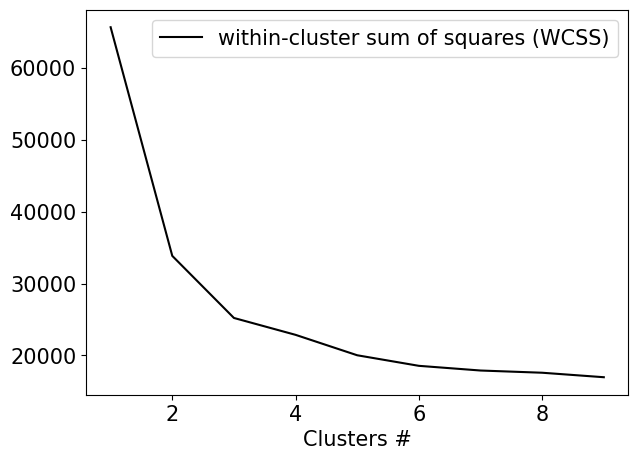

In [20]:
#LA ON DEVRAIT VOIR UN COUDE ET ON VOIT PAS DONC BIZARRE

fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, len(avg_dist_samples)+1), avg_dist_samples, label='within-cluster sum of squares (WCSS)', c='k')

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

In [21]:
nb_clusters = 3 # The number of clusters you want

kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans)
kmeans_labels=kmeans.labels_
kmeans_clusters=kmeans.cluster_centers_

In [22]:
# LA ON RESHAPE POUR POUVOIR PLOT

flattened_mask=slice_non_background.flatten()

reshaped_clusters=[]

for cluster in kmeans_clusters:
    reshaped_cluster = np.zeros(flattened_mask.shape, dtype=cluster.dtype)
    reshaped_cluster[flattened_mask]=cluster
    reshaped_cluster=reshaped_cluster.reshape(vol_shape)
    reshaped_clusters.append(reshaped_cluster)

In [23]:
print(len(reshaped_clusters))

3


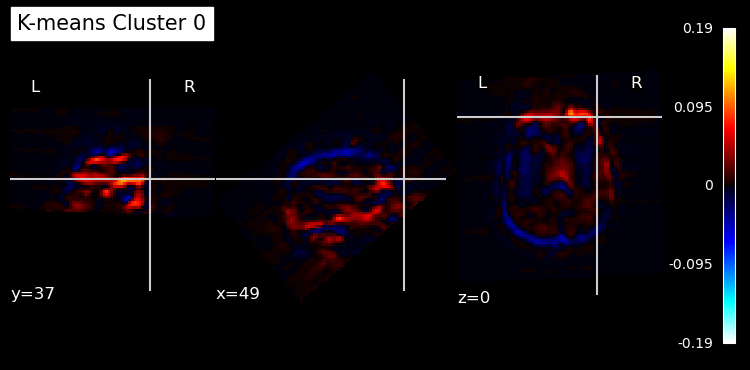

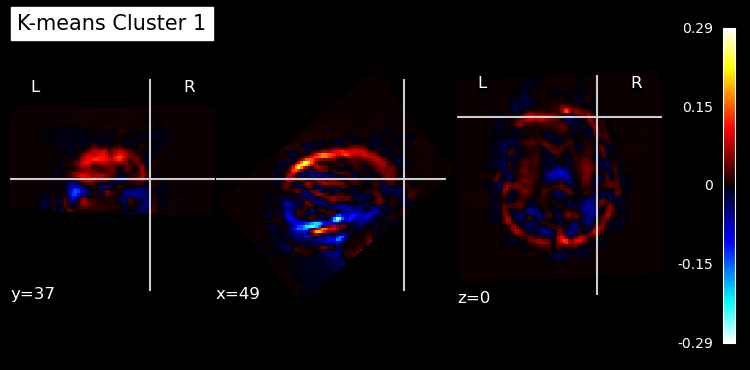

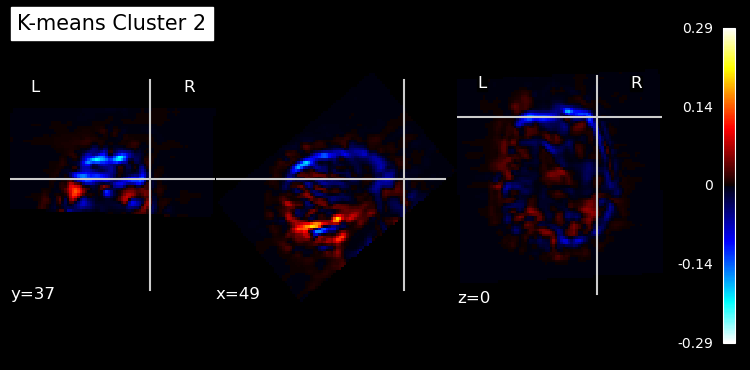

In [24]:
mean_img_ = mean_img(img)

for id, cluster in enumerate (reshaped_clusters):
    
    plot_stat_map(nib.Nifti1Image(reshaped_clusters[id], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {id}')
    plt.show()
    
    